# Import libraries

In [7]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import cv2

# Load Data

In [8]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

X_train,X_val,Y_train,Y_val=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)


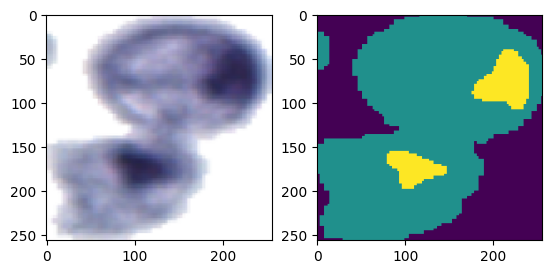

In [9]:
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(labels[0])

# 1. Optimize intensity based approach

In [10]:
X_train_gray=np.vectorize(rgb2gray, signature='(w,h,3)->(w,h)')(X_train.astype(float)/255.)
X_val_gray=np.vectorize(rgb2gray, signature='(w,h,3)->(w,h)')(X_val.astype(float)/255.)

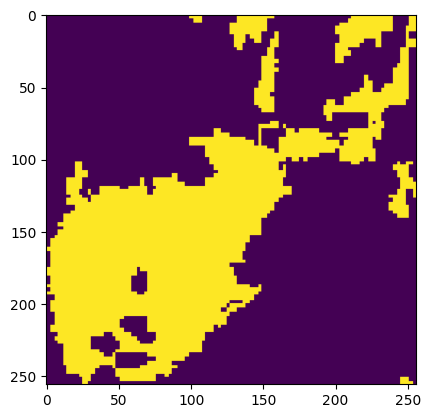

In [11]:
plt.imshow(Y_train[0]==1)

In [13]:
nucleus_train_true=(Y_train.reshape(Y_train.shape[0],-1)==2).sum(axis=1)
cytoplasm_train_true=(Y_train.reshape(Y_train.shape[0],-1)==1).sum(axis=1)
nc_ratio_train_true=nucleus_train_true/(nucleus_train_true+cytoplasm_train_true)

nucleus_val_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_val_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_val_true=nucleus_val_true/(nucleus_val_true+cytoplasm_val_true)

In [14]:
from skimage.morphology import binary_opening,binary_closing,disk
def postprocess_mask(mask):
    mask=binary_opening(mask,disk(5))
    mask=binary_closing(mask,disk(8))
    return mask

def calc_nc_ratio(img_gray,nucleus_threshold=0.4,cytoplasm_threshold=0.6):
    nucleus_mask=img_gray<=nucleus_threshold
    nucleus_mask=postprocess_mask(nucleus_mask)

    cytoplasm_mask=img_gray<=cytoplasm_threshold
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    return nucleus_area/(nucleus_area+cytoplasm_area)



In [15]:
# optimize thresholds using scipy with constraint that 0<=nucleus_threshold<=cytoplasm_threshold<=1
from scipy.optimize import minimize
from skopt import gp_minimize
from skopt.space import Real

def loss_func(thresholds):
    thresholds=sorted(thresholds)
    nc_ratio_train_pred=np.vectorize(lambda x: calc_nc_ratio(x,*thresholds),signature='(w,h)->()')(X_train_gray)
    # print(nc_ratio_train_pred,nc_ratio_train_true)
    stat=spearmanr(nc_ratio_train_pred,nc_ratio_train_true,nan_policy="omit")[0]
    # print(stat)
    if np.isnan(stat): return 0
    return -stat

# res=minimize(loss_func,[0.4,0.6],bounds=[(0,1),(0,1)],method='L-BFGS-B')
# Define the bounds for the optimization
space = [
    Real(0, 1, name='threshold1'),
    Real(0, 1, name='threshold2')
]

# Perform the optimization
res = gp_minimize(loss_func, space, x0=(0.4,0.6), n_calls=30, acq_optimizer="lbfgs", random_state=0, n_jobs=-1, verbose=True)

Iteration No: 1 started. Evaluating function at provided point.


C:\Users\JOKER\AppData\Local\Temp\ipykernel_25432\1400725143.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return nucleus_area/(nucleus_area+cytoplasm_area)


Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 3.7201
Function value obtained: -0.5444
Current minimum: -0.5444
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.6923
Function value obtained: -0.6369
Current minimum: -0.6369
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.7591
Function value obtained: -0.4550
Current minimum: -0.6369
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.7609
Function value obtained: -0.5481
Current minimum: -0.6369
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.7509
Function value obtained: -0.0000
Current minimum: -0.6369
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. 

C:\Users\JOKER\AppData\Local\Temp\ipykernel_25432\3712402715.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stat=spearmanr(nc_ratio_train_pred,nc_ratio_train_true,nan_policy="omit")[0]


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 4.7849
Function value obtained: 0.0000
Current minimum: -0.6861
Iteration No: 13 started. Searching for the next optimal point.
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 3.8565
Function value obtained: -0.6858
Current minimum: -0.6861
Iteration No: 14 started. Searching for the next optimal point.


C:\Users\JOKER\AppData\Local\Temp\ipykernel_25432\1400725143.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return nucleus_area/(nucleus_area+cytoplasm_area)


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 3.8387
Function value obtained: -0.6132
Current minimum: -0.6861
Iteration No: 15 started. Searching for the next optimal point.
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.7591
Function value obtained: -0.6872
Current minimum: -0.6872
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 3.8642
Function value obtained: -0.6843
Current minimum: -0.6872
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 3.8259
Function value obtained: -0.6818
Current minimum: -0.6872
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 3.8156
Function value obtained: -0.6573
Current minimum: -0.6872
Iteration No: 19 st

C:\Users\JOKER\AppData\Local\Temp\ipykernel_25432\3712402715.py:10: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  stat=spearmanr(nc_ratio_train_pred,nc_ratio_train_true,nan_policy="omit")[0]


Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 3.9038
Function value obtained: 0.0000
Current minimum: -0.6915
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.8941
Function value obtained: -0.6921
Current minimum: -0.6921
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.8094
Function value obtained: -0.6847
Current minimum: -0.6921
Iteration No: 26 started. Searching for the next optimal point.
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.8885
Function value obtained: -0.6729
Current minimum: -0.6921
Iteration No: 27 started. Searching for the next optimal point.


C:\Users\JOKER\AppData\Local\Temp\ipykernel_25432\1400725143.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return nucleus_area/(nucleus_area+cytoplasm_area)


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 3.9361
Function value obtained: 0.0000
Current minimum: -0.6921
Iteration No: 28 started. Searching for the next optimal point.
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.9428
Function value obtained: -0.6882
Current minimum: -0.6921
Iteration No: 29 started. Searching for the next optimal point.
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.8815
Function value obtained: -0.6691
Current minimum: -0.6921
Iteration No: 30 started. Searching for the next optimal point.
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.8851
Function value obtained: -0.6895
Current minimum: -0.6921


In [15]:
final_thresholds=sorted(res.x_iters[res.func_vals.argmin()])
pd.to_pickle(final_thresholds,"final_thresholds.pkl")

In [16]:
nc_ratio_val_pred=np.vectorize(lambda x: calc_nc_ratio(x,*final_thresholds),signature='(w,h)->()')(X_val_gray)

In [17]:
spearmanr(nc_ratio_val_pred,nc_ratio_val_true,nan_policy="omit")

SignificanceResult(statistic=np.float64(0.7247654784240152), pvalue=np.float64(1.2356183311967451e-07))

In [18]:
np.abs(nc_ratio_val_pred-nc_ratio_val_true).mean()

np.float64(0.13502775738286849)

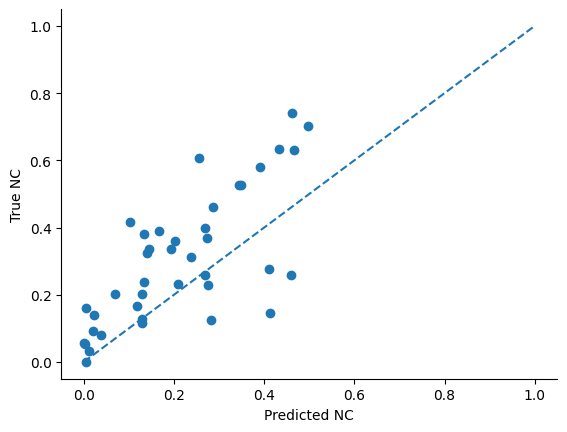

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_val_pred,nc_ratio_val_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

# KMeans Approach

In [5]:
from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage import data, segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from scipy import ndimage as ndi
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(im_gray, distances=[5], angles=[0], levels=256, properties=['dissimilarity', 'correlation']):
    """
    Extract GLCM features from a grayscale image.

    Parameters:
    - im_gray: Grayscale input image (2D array).
    - distances: List of pixel pair distances for GLCM computation.
    - angles: List of angles (in radians) for GLCM computation.
    - levels: Number of gray levels in the image.
    - properties: List of GLCM properties to compute.

    Returns:
    - glcm_features: N-dimensional image with GLCM features stacked at each pixel location.
    """
    glcm_features = np.zeros(im_gray.shape + (len(distances) * len(angles) * len(properties),), dtype=np.float32)
    
    for i, d in enumerate(distances):
        for j, a in enumerate(angles):
            glcm = graycomatrix(im_gray, distances=[d], angles=[a], levels=levels, symmetric=True, normed=True)
            for k, prop in enumerate(properties):
                prop_values = graycoprops(glcm, prop)
                glcm_features[:,:,i*len(angles)*len(properties) + j*len(properties) + k] = prop_values
                
    return glcm_features

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(
        ndi.convolve(image, np.real(kernel), mode='wrap') ** 2
        + ndi.convolve(image, np.imag(kernel), mode='wrap') ** 2
    )


def return_gabor_filter_results(img_gray):
    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []
    for theta in np.linspace(0, 1.01, 3):
        theta = theta / 4.0 * np.pi
        for frequency in (0.1, 0.2, 0.3, 0.4):
            kernel = gabor_kernel(frequency, theta=theta)
            params = f"theta={theta * 180 / np.pi},\nfrequency={frequency:.2f}"
            kernel_params.append(params)
            # Save kernel and the power image for each image
            results.append((kernel, power(img_gray, kernel) ))
    return results

def extract_features(img,
                    sigma_min = 1,
                    sigma_max = 16):
    img_gray = (rgb2gray(img)*255.).astype(np.uint8)
    glcm_features = extract_glcm_features(img_gray)
    gabor_filter_results = return_gabor_filter_results(img_gray)
    new_feature_img=np.transpose(np.stack([res[1].astype(float) for res in gabor_filter_results]),(1,2,0))
    features_func = partial(
        feature.multiscale_basic_features,
        intensity=True,
        edges=False,
        texture=True,
        sigma_min=sigma_min,
        sigma_max=sigma_max,
        channel_axis=-1,
    )
    multi_scale_features = features_func(img)
    all_features = np.concatenate([img,new_feature_img,glcm_features,multi_scale_features],axis=2)
    return all_features



In [6]:
X_train_features=np.vectorize(extract_features,signature='(w,h,3)->(w,h,62)')(X_train)
X_val_features=np.vectorize(extract_features,signature='(w,h,3)->(w,h,62)')(X_val)

NameError: name 'X_train' is not defined

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

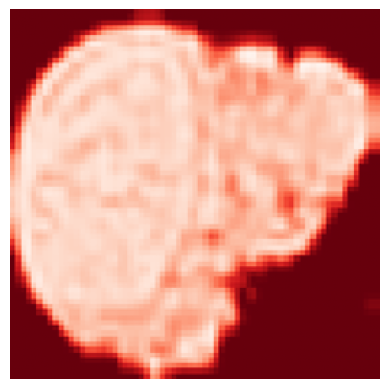

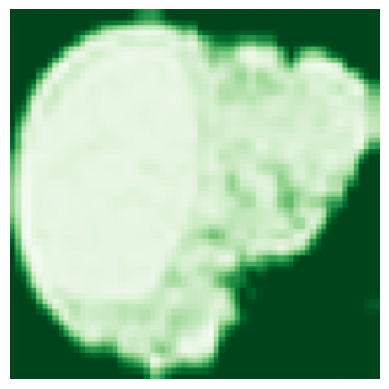

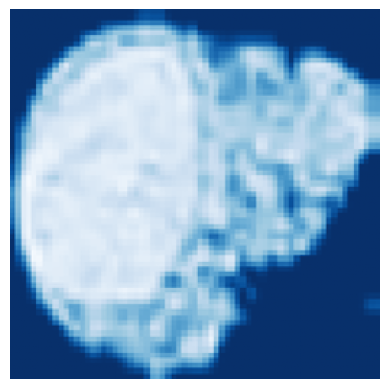

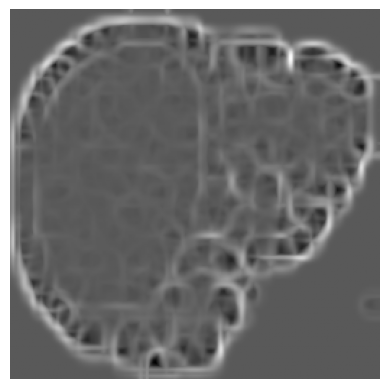

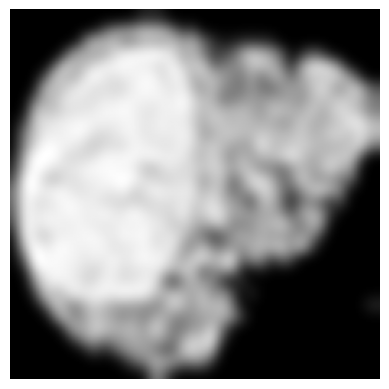

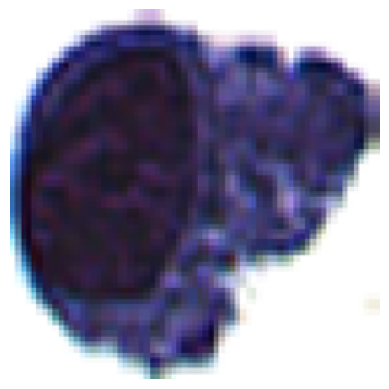

In [22]:
i=1
plt.figure()
plt.imshow(X_train_features[1][...,0],cmap="Reds")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features[1][...,1],cmap="Greens")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features[1][...,2],cmap="Blues")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features[1][...,37],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features[1][...,53],cmap="gray_r")
plt.axis("off")
plt.figure()
plt.imshow(X_train_features[1][...,:3]/255)
plt.axis("off")

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

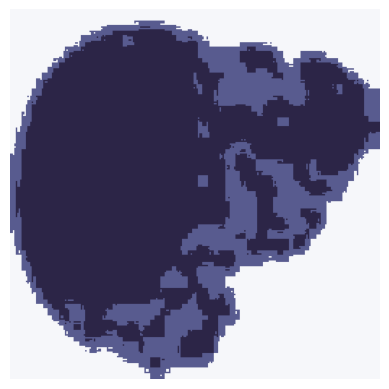

In [23]:
img_=X_train_features[1][...,:3]
Z = img_.reshape((-1,3))
Z = np.float32(Z)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img_.shape))
plt.imshow(res2)
plt.axis("off")

In [ ]:
# instead fit one classifier per image in the stack, returning the feature importances
def fit_image_stack(X,Y):
    clf=RandomForestClassifier(n_estimators=100,random_state=42)
    clf.fit(X.reshape(np.prod(X.shape[:-1]),-1),Y.reshape(-1))
    return clf.feature_importances_

# now use dask with progressbar to parallelize the fitting
import dask
from dask.diagnostics import ProgressBar
with ProgressBar():
    feature_importances=dask.compute(*[dask.delayed(fit_image_stack)(x,y) for x,y in zip(X_train_features,Y_train)],scheduler='processes', num_workers=16)


[########################################] | 100% Completed | 17m 44s


In [35]:
import pickle
with open('2_feature_importances_data.pkl', 'wb') as f:
  pickle.dump(feature_importances, f)
print("Saved in 2_feature_importances_data.pkl")

Saved in 2_feature_importances_data.pkl


In [4]:
import pickle

# Load the data from the pickle file
with open('2_feature_importances_data.pkl', 'rb') as f:
    feature_importances = pickle.load()

# Print or inspect the loaded data
print("Loaded feature importances:", feature_importances)

TypeError: load() missing required argument 'file' (pos 1)

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# compute most important features
ntop=15
top_features=np.where(np.argsort(np.vstack([np.argsort(-feature_importance) for feature_importance in feature_importances]).mean(0))<ntop)[0]

# pick top features
X_train_features_top=X_train_features[...,top_features]
X_val_features_top=X_val_features[...,top_features]

# calculate standard scaler and PCA on top features
scaler=StandardScaler()
X_train_features_top_vectorized=scaler.fit_transform(X_train_features_top.reshape(-1,ntop))
pca=PCA(n_components=2)
X_train_features_top_pca=pca.fit_transform(X_train_features_top_vectorized)
# do for val set
X_val_features_top_vectorized=scaler.transform(X_val_features_top.reshape(-1,ntop))
X_val_features_top_pca=pca.transform(X_val_features_top_vectorized)


NameError: name 'np' is not defined

In [26]:
# for each image, calculate KMeans clustering on top 10 features
def fit_kmeans(X):
    ndim=X.shape[-1]
    kmeans=KMeans(n_clusters=4,random_state=42)
    kmeans.fit(X.reshape(-1,ndim))
    return kmeans.labels_.reshape(X.shape[0],X.shape[1])

# reshape images back into 256x256x2 for PCA
X_train_features_top_pca_img=X_train_features_top_pca.reshape(X_train_features_top.shape[0],X_train_features_top.shape[1],X_train_features_top.shape[2],2)
X_val_features_top_pca_img=X_val_features_top_pca.reshape(X_val_features_top.shape[0],X_val_features_top.shape[1],X_val_features_top.shape[2],2)

# run KMeans on PCA features
Y_train_kmeans=np.vectorize(fit_kmeans,signature='(w,h,2)->(w,h)')(X_train_features_top_pca_img)
Y_val_kmeans=np.vectorize(fit_kmeans,signature='(w,h,2)->(w,h)')(X_val_features_top_pca_img)

In [27]:
# for each output, calculate average gray intensity of each kmeans cluster
y_val_nc_ratio=[]
for y_val_kmeans,x_val_gray in zip(Y_val_kmeans,X_val_gray):
    cluster_intensities=[]
    for i in range(4):
        cluster_intensities.append(x_val_gray[y_val_kmeans==i].mean())
    # nucleus is lowest, cytoplasm is medium, background is highest, assign masks
    cluster_intensities=np.argsort(cluster_intensities)
    nucleus_mask=y_val_kmeans==cluster_intensities[0]
    cytoplasm_mask=np.isin(y_val_kmeans,cluster_intensities[1:-1])

    # postprocess masks
    nucleus_mask=postprocess_mask(nucleus_mask)
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    # calculate nc ratio
    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    nc_ratio=nucleus_area/(nucleus_area+cytoplasm_area)
    y_val_nc_ratio.append(nc_ratio)


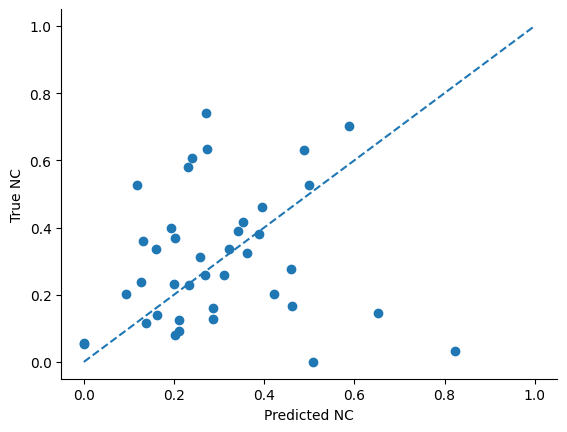

In [28]:
import seaborn as sns
plt.scatter(y_val_nc_ratio,nc_ratio_val_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

In [29]:
spearmanr(y_val_nc_ratio,nc_ratio_val_true,nan_policy="omit")

SignificanceResult(statistic=np.float64(0.17533655444027457), pvalue=np.float64(0.2791760368251256))

In [30]:
np.abs(y_val_nc_ratio-nc_ratio_val_true).mean()

np.float64(0.1726289117245214)

# now the same workflow in RGB

In [31]:
Y_train_kmeans=np.vectorize(fit_kmeans,signature='(w,h,3)->(w,h)')(X_train)
Y_val_kmeans=np.vectorize(fit_kmeans,signature='(w,h,3)->(w,h)')(X_val)

y_val_nc_ratio=[]
for y_val_kmeans,x_val_gray in zip(Y_val_kmeans,X_val_gray):
    cluster_intensities=[]
    for i in range(4):
        cluster_intensities.append(x_val_gray[y_val_kmeans==i].mean())
    # nucleus is lowest, cytoplasm is medium, background is highest, assign masks
    cluster_intensities=np.argsort(cluster_intensities)
    nucleus_mask=y_val_kmeans==cluster_intensities[0]
    cytoplasm_mask=np.isin(y_val_kmeans,cluster_intensities[1:-1])

    # postprocess masks
    nucleus_mask=postprocess_mask(nucleus_mask)
    cytoplasm_mask=postprocess_mask(cytoplasm_mask)
    cytoplasm_mask=np.logical_and(cytoplasm_mask,~nucleus_mask)

    # calculate nc ratio
    nucleus_area=np.sum(nucleus_mask)
    cytoplasm_area=np.sum(cytoplasm_mask)
    nc_ratio=nucleus_area/(nucleus_area+cytoplasm_area)
    y_val_nc_ratio.append(nc_ratio)


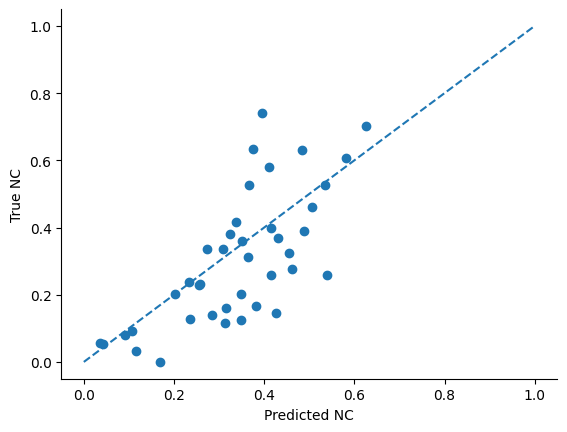

In [32]:
plt.scatter(y_val_nc_ratio,nc_ratio_val_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

In [33]:
spearmanr(y_val_nc_ratio,nc_ratio_val_true,nan_policy="omit")

SignificanceResult(statistic=np.float64(0.7283302063789869), pvalue=np.float64(9.986285763982764e-08))

In [34]:
np.abs(y_val_nc_ratio-nc_ratio_val_true).mean()

np.float64(0.10755009319001148)

In [1]:
# classification report
from sklearn.metrics import classification_report

# Flatten predictions and true labels for validation set
y_val_true_flat = Y_val.flatten()
y_val_kmeans_flat = Y_val_kmeans.flatten()

# Generate classification report
class_names = ['background', 'cytoplasm', 'nucleus']
print("Validation Set Pixelwise Classification Report:")
print(classification_report(y_val_true_flat, y_val_kmeans_flat, target_names=class_names))



NameError: name 'Y_val' is not defined